In this notebook we will create some synthetic data and fit it with a hidden Markov model.

In [82]:
import numpy as np
import matplotlib.pyplot as plt


To begin, we will generate a synthetic time series of data. The latent variable `z` in our model will be binary, where `z[n]=0` corresponds to the first latent state at timestep `n`, and `z[n]=1` corresponds to the other latent state. The transition probabilities between `z[n]` and `z[n+1]` are described by the 2x2 matrix `trans_prob`. At each `n`, an observation `x[n]` is drawn from a normal distribution with mean and covariance `(m1, s1)` (if `z[n]=0`) or `(m2, s2)` (if `z[n]=1`).

The block of code below defines the parameters for our generating model. We will later try to estimate these parameters given the observations `x`.

In [83]:
# Means and covariances for the two Gaussian emission distributions:
m1 = np.array([1,1])
m2 = np.array([-1,-1])
m = [m1, m2]
s1 = 0.5*np.eye(2)
s2 = 0.5*np.eye(2)
s = [s1, s2]

# trans_prob[i,j] is the probability of transitioning from state i to state j:
trans_prob = np.array([[0.8, 0.2], [0.1, 0.9]])
#trans_prob = np.array([[0.5, 0.5], [0.5, 0.5]])

**Exercise**: Using the parameters defined above, generate synthetic data `z` (a 1D array of length `n_steps`) and `x` (A 2D array of shape `n_steps` by 2, where 2 is the dimensionality of each observation). Make a plot of each of these variables.

<IPython.core.display.Javascript object>


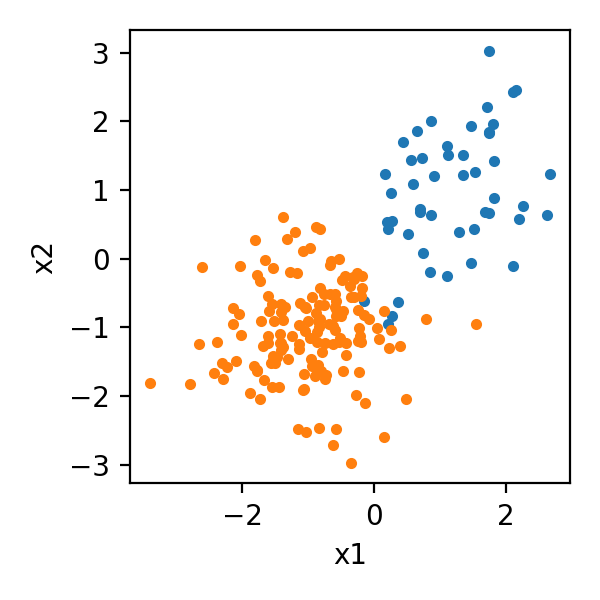

<IPython.core.display.Javascript object>


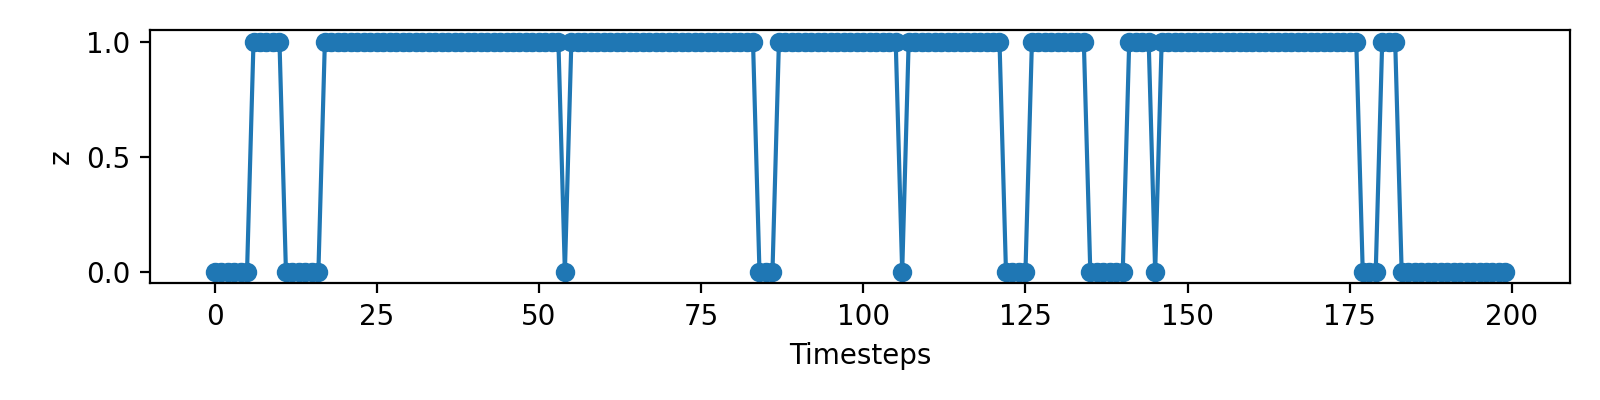

In [84]:
## Solution ##

n_steps = 200  # number of timesteps in our sequence

# Generate the synthetic data:
z = np.zeros(n_steps)  # latent states (0 or 1)
state = 0  # the initial state
x = np.zeros((n_steps, 2))  # observations
x[0] = np.random.multivariate_normal(m1, s1)  # initial observation
for nn in range(1, n_steps):
    state = np.random.choice(2, p=trans_prob[state])
    z[nn] = state
    x[nn,:] = np.random.multivariate_normal(m[state], s[state])
    
# Plot the results
plt.figure(figsize=(3,3))
plt.plot(x[z==0,0], x[z==0,1], '.')
plt.plot(x[z==1,0], x[z==1,1], '.')
plt.xlabel('x1')
plt.ylabel('x2')
plt.tight_layout()

plt.figure(figsize=(8,2))
plt.plot(z, '-o')
plt.xlabel('Timesteps')
plt.ylabel('z')
plt.tight_layout()

Our goal now will be to pretend that we don't know the parameters or latent states and infer these using a hidden Markov model. We'll use the `hmmlearn` package, which you may need to install before proceeding. To install the package, try running `pip install hmmlearn` in the terminal, or read the documentation here: https://github.com/hmmlearn/hmmlearn.

Let's import the package we'll need and read the documentation for `GaussianHMM`, a class which fits an HMM to data assuming Gaussian emissions.

In [85]:
from hmmlearn import hmm

hmm.GaussianHMM?

**Exercise**: Follow the example given at the following link to fit the data with an HMM, assuming two latent states (`n_components=2`):
https://hmmlearn.readthedocs.io/en/stable/tutorial.html#training-hmm-parameters-and-inferring-the-hidden-states

Compute the sequence of latent states inferred by the model, calling this `z_pred`, and compare this to the true sequence of hidden states by computing the correlation coefficient:
$$
\rho = \frac{\frac{1}{N}\sum_{n=1}^N(z_n - E(z)) (z^\mathrm{pred}_n - E(z^\mathrm{pred}))}
{\sqrt{\mathrm{Var}[z] \mathrm{Var}[z^\mathrm{pred}]}}.
$$

In [86]:
## Solution ##

# Fit an HMM to the data with 2 states:
model = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=1000)
model.fit(x[:,:])
z_pred = model.predict(x)  
print('Predicted latent states: ', z_pred[:20])

# Switch the 0 and 1 labels if they don't match what we used in the generating model:
if (np.mean(z_pred) - 0.5)*(np.mean(z) - 0.5) < 0:
    z_pred = 1 - z_pred

# Compute the correlation coefficient:
rho = np.mean((z - np.mean(z))*(z_pred - np.mean(z_pred)))/(np.std(z)*np.std(z_pred))
print('Correlation coefficient: ', rho)
print('Easier version: ', np.corrcoef(z, z_pred)[0,1])

Predicted latent states:  [1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0]
Correlation coefficient:  0.9862894527123313
Easier version:  0.9862894527123294


In [89]:
# Compare the true and estimated parameters:

print('\n Estimated covariance matrices: \n', model.covars_)
print('\n True covariance matrices: \n', s1, s2)

print('\n Estimated observation means: \n', model.means_)
print('\n True observation means: \n', m1, m2)

print('\n Estimated transition probabilities: \n', model.transmat_)
print('\n True transition probabilities: \n', trans_prob)


 Estimated covariance matrices: 
 [[[0.54513733 0.02665875]
  [0.02665875 0.45725321]]

 [[0.5133383  0.22160013]
  [0.22160013 0.76047676]]]

 True covariance matrices: 
 [[0.5 0. ]
 [0.  0.5]] [[0.5 0. ]
 [0.  0.5]]

 Estimated observation means: 
 [[-0.99473556 -1.0381544 ]
 [ 1.18693088  0.98355386]]

 True observation means: 
 [1 1] [-1 -1]

 Estimated transition probabilities: 
 [[0.93838689 0.06161311]
 [0.20458131 0.79541869]]

 True transition probabilities: 
 [[0.8 0.2]
 [0.1 0.9]]
